# Gesture Recognition
### Jack Shoemaker

# Gestures 
- Outside of spoken language we often use our hands for communicating to others
- This can be accomplished through sign language or common gestures such as 👍
- Gesture recognition therefore has a wealth of applications in the human computer interaction space

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Color Spaces 
- Color spaces are different ways of representing colors in images 
- RGB for example represents colors through a composite of red, green, and blue
- Hue Saturation Value, HSV, is a cylindrical color space where hue represents the angle around the cylinder and the saturation represents the depth from the origin
- YCbCr represents color through luminance(y) and the CbCr represents the blue red chrominance respecitvely
- These color spaces can be transformed from one to another

# Thresholding
- Human skin color primarily exists in certain regions within color spaces
- Different research papers have found ranges of values for differnt color spaces in general lighting conditions that captures most skin colors
- Using a combination of these skin is able to be segmented out from an image
- This allows for fast hand segmentation with the main drawback that it requires the scene be well lit

In [2]:
def processAndSegment(input_img:np.array)->np.array:
    # denoise/smooth image 
    input_img = cv.GaussianBlur(input_img, (5,5), 0)
    
    # assuming input image is in BGR format
    blue = input_img[:,:,0]
    green = input_img[:,:,1]
    red = input_img[:,:,2]

    # extract hsv and ycrcb representation of img 
    hsv_img = cv.cvtColor(input_img, cv.COLOR_BGR2HSV_FULL)
    ycrcb = cv.cvtColor(input_img, cv.COLOR_BGR2YCrCb)
    y,cr,cb = np.dsplit(ycrcb, 3)
    h,s,_ = np.dsplit(hsv_img, 3)
    s = s/255.0 # normalize saturation value

    # using thresholding segment image into skin color and non-skin color region
    # threshold values found through reference [1]
    # note: h val is halved because of openCV's hsv h range being 180 and not 360 
    hs_mask = (0<=h) & (h<=25) & (0.23<=s) & (s<=0.68)
    rgb_mask = (red>95) & (green>40) & (blue>20) & (red>green) & (red>blue) & (abs(red-green)>15)
    ycrcb_mask = (cr>135) & (cr<=(1.5862*cb)+20) & (cr>=(0.3448*cb)+76.2069) & (cr>=(-4.5652*cb)+234.5652) & (cr<=(-1.15*cb)+301.75) & (cr<=(-2.2857*cb)+432.85) & (y>80)
    overall_mask = (np.squeeze(hs_mask) & rgb_mask) | (rgb_mask & np.squeeze(ycrcb_mask))
    
    # cut out wrist if exists 
    # if region is longer vert then cut off after it widens 
    # if region is 
    return overall_mask

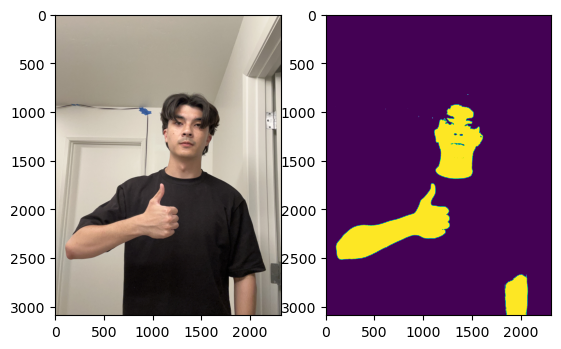

In [3]:
demo_img = cv.imread("gesture_data/test_images/thumbs-up-j2.jpg")
f, axis = plt.subplots(1,2)
mask = processAndSegment(demo_img)
axis[0].imshow(demo_img[:,:,::-1])
axis[1].imshow(mask)

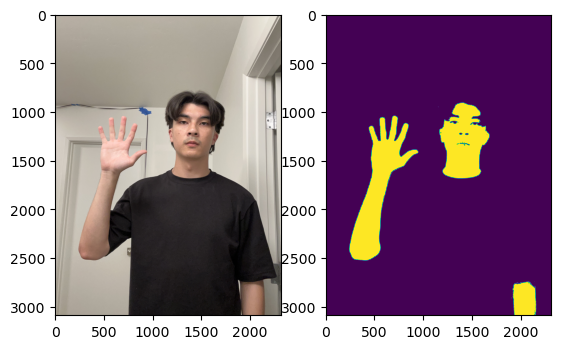

In [5]:
demo_img2 = cv.imread("gesture_data/test_images/wave-j2.jpg")
f, axis = plt.subplots(1,2)
mask = processAndSegment(demo_img2)
axis[0].imshow(demo_img2[:,:,::-1])
axis[1].imshow(mask)

In [6]:
# Isolate the palm from the forearm if applicable 
def isolateWrist(mask:np.array):
    contours,_ = cv.findContours(mask.astype("uint8"),2,1)

    # hand area should be largest portion of image
    region_of_interest = max(contours, key=cv.contourArea)

    x,y,width,height = cv.boundingRect(region_of_interest)
    
    # if ratio of bounding box is greater than threshold, image likely includes forearm
    # this isolates the upper palm and fingers from rest of arm 
    if(width/height > 1.40):
        max_height = 0
        max_height_x = x
        # person can be right or left handed, so must keep track of second widest point 
        second_max_height_x = x
        for i in range(x, x+width):
            points = np.where((region_of_interest[:,0,0] == i))[0]
            if(len(points)>0):
                min_y = np.min(region_of_interest[points, 0,1])
                max_y = np.max(region_of_interest[points, 0,1])
                height = max_y-min_y
                if(height>max_height):
                    max_height = height
                    second_max_height_x = max_height_x
                    max_height_x = i
        # extract palm region before widest point 
        hand_countor = []
        if max_height_x > second_max_height_x:
            for point in region_of_interest:
                if (point[0][0] >= max_height_x-(0.10*width)):
                    hand_countor.append(point)
        else:
            for point in region_of_interest:
                if (point[0][0] <= max_height_x+(0.10*width)):
                    hand_countor.append(point)
        hand_countor = np.array(hand_countor)
        return hand_countor
    elif(height/width > 1.40):
        # Iterate through each horizontal segment of the bounding rectangle
        max_width = 0
        max_width_y = y
        for i in range(y, y + height):
            # Find the width at this horizontal segment
            points = np.where((region_of_interest[:,0,1] == i))[0]
            if (len(points) > 0):
                min_x = np.min(region_of_interest[points, 0, 0])
                max_x = np.max(region_of_interest[points, 0, 0])
                width = max_x - min_x
                if (width > max_width):
                    max_width = width
                    max_width_y = i
        # Extract palm region above widest point 
        hand_countor = []
        for point in region_of_interest:
            if (point[0][1] <= max_width_y+(0.10*height)):
                hand_countor.append(point)
        hand_countor = np.array(hand_countor)
        return hand_countor
    else:
        return region_of_interest

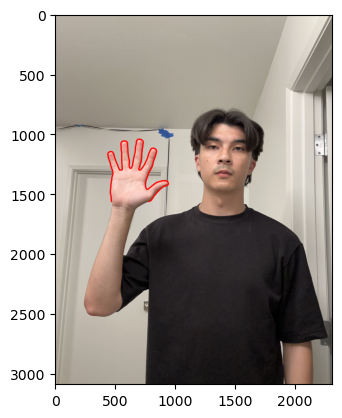

In [7]:
cv.drawContours(demo_img2, isolateWrist(processAndSegment(demo_img2)), -1, (0, 0, 255), 10)
plt.imshow(demo_img2[:,:,::-1])

# Counting Fingers 
- We can use the contour created for the hand to create the contours convex hull
- With the convex hull we can find the valleys between fingers getting number of fingers 
![alt text](convex.png "Convex Hull")
Image source: https://medium.com/analytics-vidhya/contours-and-convex-hull-in-opencv-python-d7503f6651bc

In [8]:
def countFingers(contour):
    hull = cv.convexHull(contour, returnPoints=False)
    # Find convexity defects which corresponds to valleys between fingers
    defects = cv.convexityDefects(contour, hull)
    finger_count = 0
    far = []
    for i in range(defects.shape[0]):
        start_ind, end_index, farthest_point, depth = defects[i,0]
        # threshold depth value
        if(depth > 10000):
            finger_count +=1
            far.append(tuple(contour[farthest_point][0]))
    return finger_count, far

2


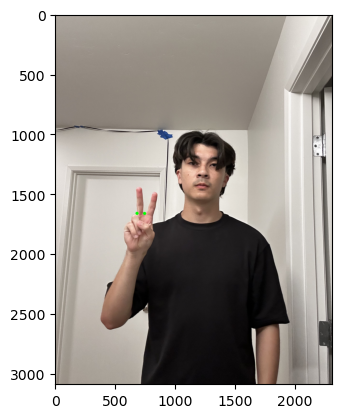

In [9]:
image = cv.imread("gesture_data/test_images/peace-sign-j.jpeg")
num,far = countFingers(isolateWrist(processAndSegment(image)))
for dot in far:
    cv.circle(image, dot, 5, [0,255,0],15)
plt.imshow(image[:,:,::-1])
print(num)

4


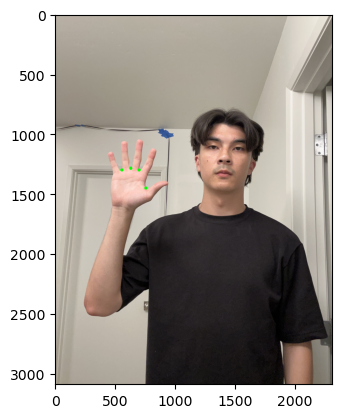

In [10]:
image = cv.imread("gesture_data/test_images/wave-j2.jpg")
num,far = countFingers(isolateWrist(processAndSegment(image)))
for dot in far:
    cv.circle(image, dot, 5, [0,255,0],15)
plt.imshow(image[:,:,::-1])
print(num)

# Contours and Moments
- With the contours we capture the gesture hand shape
- Given a contour we can then derive the contour's moments 
- Moments capture properties of shapes/contours 
- Can then derive the Hu moments from the normalized central moments, these moments are rotation, scale, and translation invariant 
- Using these Hu moments we can then perform object recognition 

In [ ]:
# load hu moments for sample images 
wave_hu = np.load("gesture_data/wave_hu_moments.npy")
peace_hu = np.load("gesture_data/peace_sign_hu_moments.npy")
question_hu = np.load("gesture_data/question_hu_moments.npy")
thumbs_hu = np.load("gesture_data/thumbs_up_hu_moments.npy")
class_hus = [["wave", wave_hu, 5], ["peace", peace_hu, 2], ["question", question_hu, 1], ["thumbs up", thumbs_hu, 1]]

In [11]:
# using hu moments compute the sim score between the two shapes
def compute_sim_moments(hu_1, hu_2)->float:
    sum = 0.0
    for i in range(len(hu_1)):
        if(hu_1[i] > 1e-5 and hu_2[i] > 1e-5):
            # transform moments, then compute l1 distance
            mH_1 = np.sign(hu_1[i])*np.log10(np.abs(hu_1[i]))
            mH_2 = np.sign(hu_2[i])*np.log10(np.abs(hu_2[i]))
            sum += np.abs(1/mH_1 - 1/mH_2)
    return sum

def checkGesture(input_img: np.array)->str:
    # get image mask for skin regions
    overall_mask = processAndSegment(input_img)

    # generate contour by isolating wrist 
    region_of_interest = isolateWrist(overall_mask)

    # finger count
    count,_ = countFingers(region_of_interest)
    print(count)
    # find hu moments for contours
    moments = cv.moments(region_of_interest)
    hu_moments = cv.HuMoments(moments)

    # compute sim scores with precomputed hu moments for gestures 
    label = "none"
    lowest_sim = np.inf
    for curr_label, label_hus, finger_count in class_hus:
        for hus in label_hus:
            # weight the sim score by the difference in finger count 
            sim = (5e-2*abs(finger_count-count))+compute_sim_moments(hu_moments, hus)
            if(sim < 0.50 and sim < lowest_sim):
                lowest_sim = sim
                label = curr_label
    print(lowest_sim)
    return label

2


NameError: name 'class_hus' is not defined

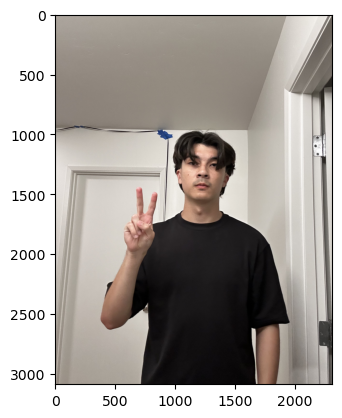

In [12]:
# image = cv.imread("gesture_data/test_images/wave-j2.jpg")
# image = cv.imread("gesture_data/test_images/thumbs-up-8.jpg")
# image = cv.imread("gesture_data/test_images/que-8.jpg")
# image = cv.imread("gesture_data/test_images/wave-8.jpg")
# image = cv.imread("gesture_data/test_images/peace-sign-8.jpg")
image = cv.imread("gesture_data/test_images/peace-sign-j.jpeg")
plt.imshow(image[:,:,::-1])
print(checkGesture(image))

# Advantages
- Fast inference time and low computational costs 
- Does not require large amounts of data
- Fits well to an individual's hand given low amounts of sample data 
# Disadvantages
- Does not generalize as well as modern deep learning approaches
- Segmentation is highly dependent on the scene being well light 

# References 
[1]S. Kolkur, D. Kalbande, P. Shimpi, C. Bapat, and J. Jatakia, "Human Skin Detection Using RGB, HSV and YCbCr Color Models", roceedings of the International Conference on Communication and Signal Processing 2016 (ICCASP 2016), https://www.atlantis-press.com/proceedings/iccasp-16/25871632

[2]A. Kapitanov, K. Kvanchiani, A. Nagaev, R. Kraynov, A. Makhliarchuk,"HaGRID -- HAnd Gesture Recognition Image Dataset", Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (WACV), https://github.com/hukenovs/hagrid?tab=readme-ov-file

[3]Y. Liu, Y. Yin and S. Zhang, "Hand Gesture Recognition Based on HU Moments in Interaction of Virtual Reality," 2012 4th International Conference on Intelligent Human-Machine Systems and Cybernetics, https://ieeexplore.ieee.org/abstract/document/6305646?casa_token=aSaaJlKbUI4AAAAA:AMa4H35cm2dyAYvJx34ItKG_TSvIIUFh-2F-PD4caMisZWDEsYtzt6NoubSQwrWfNHVLwoU